# Executive summary

## Business Goals

In recent years, construction accidents happens a lot in Singapore and other countries worldwide. It results in significant human suffering, lagged project schedule, damaged reputation of the company and industry involved and other negative influence. Therefore, some indicators, inspection findings, audit score and safety climate survey are proposed to help construction-related organizations. Due to the unreliability of these indicators, we have to mine some useful data in a Fatality and Catastrophe Investigation Summary to pinpoint occupations and workplace activities that face higher safety risks than others.

## Findings

Based on the result of analysis, we find that (add some noticeable findings)

It is recommended that some appropriate measures to mitigate the identified risks and prevent the occurrence of similar accidents.

# Introduction

## Purpose of analysis

In recent years, the construction industry remains the top contributor for workplace fatalities in Singapore. Likewise, poor construction safety performance is common to see in other countries, which causes significant human suffering, property damage and great time consumption. To improve construction safety performance, many have proposed the use of leading indicators such as inspection findings, audit score and safety climate survey. But the reliability of these indicators are still not validated. Thus, a Fatality and Catastrophe Investigation Summary is mined to identify higher safety risks occupations and work place activities.

## Business & Text Mining goals

To realize our business target, which is to reduce construction accidents, we need to answer below questions in details:

1. Which type of accidents (in terms of main causes) are more common in fatal or catastrophic accidents?

2. What are the more risky occupations in such accidents?

3. Which parts of human body are more prone to be injured in such accidents.

4. What are the common activities that the victims were engaged in prior to the accident?

Virtually, these four questions can be converted into four text mining goals:

- Identify the most frequent type of accidents in fatal or catastrophic accidents.

- Identify high-risk occupations in fatal or catastrophic accidents.

- Identify high-risk injured parts of human body in fatal or catastrophic accidents.

- Identify the most common engaged activities of victims.

In this way, it is possible to take some preventative measures to reduce construction accidents.

# Main Body 

## Preprocessing

Preprocessing is an essential step for text mining before conducting the actual process. Basically, some common-used preprocessing techniques, like converting all characters to lowercase, tokenization, striping spare whitespace and pos tagging, were applied on the data. We also merge two causes "Other" and "Others" together.
In addition, since according to observation, there are a few corrupted accident records exist in osha dataset, we reobtain these records by recrawling from their source website: https://www.osha.gov/pls/imis/accidentsearch.accident_detail based on accident id.

In [3]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.tag.stanford import StanfordPOSTagger

# load data file
msia = pd.read_excel('data/MsiaAccidentCases.xlsx')
osha = pd.read_excel('data/osha.xlsx', header=None, parse_cols='A:D')

Preview raw dataset

In [4]:
msia.head(5)

,Cause,Title Case,Summary Case
0,Caught in/between Objects,Died being caught in between machines,The accident occurred as victim was assigned t...
1,Other,Died been buried,The accident occurred during the floor concret...
2,Struck By Moving Objects,Died crushed by entrance arch,Victim with four co-workers were installing wo...
3,Caught in/between Objects,Died due to mine cave-in,A series of avalanche trapped victim who was m...
4,Fires and Explosion,Died being run over by a lorry,Accident involving an employee who has been ru...


In [5]:
osha.head(5)

,0,1,2,3
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 2...,burn industrial truck waste proc fac pa...
1,202561825,Employee Falls From Flatbed Trailer And Later...,On August 30 2013 Employee #1 was working f...,truck flatbed truck trailer fall abdomen
2,200361855,Two Workers Are Struck By Motor Vehicle And O...,On August 27 2013 Employees #1 and #2 of T...,construction undrgrd power line highway ...
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iro...,waste proc fac industrial truck struck b...
4,201079324,Employee Is Splashed With Hot Water And Is Bu...,On July 14 2013 Employee #1 vacuum pump tr...,truck driver pump tank hot water struc...


Example of the corrupted value in the 2nd column of osha

In [6]:
osha[osha[1]==" Electric Shock "].head(5)

,0,1,2,3
62,14521470,Electric Shock,THE OWNER OF A COMPANY AND ONE OF HIS EMPLOYE...,electrical electrocuted electric shock ...
192,315964536,Electric Shock,On April 3 2012 an employee was working for...,electrical electrocuted overhead power l...
282,200452894,Electric Shock,At 3:30 p.m. on October 17 2011 a hotel mai...,electrical electrocuted maintenance air...
284,200171080,Electric Shock,A heating ventilation and air-conditioning ...,electrical electrocuted maintenance air...
285,200556546,Electric Shock,Two employees were repairing the compressor o...,electrical electrocuted electrician ele...


Example of the corrupted value in the 3rd column of osha

In [7]:
osha[osha[2]=="InspectionOpen DateSICEstablishment Name"].head(5)

,0,1,2,3
15,201703584,Worker Is Injured When Struck By Board And Th...,InspectionOpen DateSICEstablishment Name,31592899410/31/20126531Pinnacle Construction &...
34,202614863,Employee Falls Through Ceiling Suffers Contu...,InspectionOpen DateSICEstablishment Name,31706460803/26/20137363Express Services Inc
61,14493290,Employee Asphyxiated By Nitrogen In Sandblast...,InspectionOpen DateSICEstablishment Name,10107273410/27/19872813Ref-Chem Corp
187,946731,Chemical Spill No Injuries,InspectionOpen DateSICEstablishment Name,1846386901/04/19902821Walsh Divison Colloids Inc.
246,201352788,Employee Killed When Caught Between Lift Rail...,InspectionOpen DateSICEstablishment Name,30843203806/28/20051742Mader Southeast Inc.


In [ ]:
# standardized dataframe header
msia.columns = [name.split()[0] for name in msia.columns]
osha.columns = ['Accident', 'Title', 'Summary', 'Keywords']

# merge Other and Others by changing Others to Other
msia.loc[msia.Cause == 'Others', 'Cause'] = 'Other'

# Strip whitespace (including newlines) from each string in the Series/Index from left and right sides
for col in ['Title', 'Summary', 'Keywords']:
    osha[col] = osha[col].astype('str').str.strip()

# impute missing data from source website by recrawling
url = 'https://www.osha.gov/pls/imis/accidentsearch.accident_detail'
# find index containing missing value
is_missing = (osha.Summary == 'InspectionOpen DateSICEstablishment Name') | (
osha.Title.apply(lambda x: x.count(' ') <= 1))
length = sum(is_missing)
count = 0
print('Recrawling data for imputing...')
for index, row in osha.loc[is_missing].iterrows():
    print('%d/%d' % (count, length))
    page = requests.get(url, params={'id': row.Accident})  # get source page of missing record

    soup = BeautifulSoup(page.content, 'html.parser')
    strong = soup.select('#maincontain > div > p.text-center > strong')[0]
    td = soup.findAll("td", {"colspan": "8"})

    title = strong.text[strong.text.index('-') + 1:].strip()
    summary = td[1].text.strip()
    keywords = td[2].text[9:].strip().split(', ')

    osha.loc[index, 'Title'] = title
    osha.loc[index, 'Summary'] = summary
    osha.loc[index, 'Keywords'] = '  '.join(keywords)  # double spaces
    count += 1

# Using Stanford POS Tagger rather than nltk default pos tagger to get more accurate pos tag
pos_model_path = './stanford-postagger-full-2017-06-09/models/english-bidirectional-distsim.tagger'  #  modify soruce file path at here
pos_jar_path = './stanford-postagger-full-2017-06-09/stanford-postagger.jar'  #  modify soruce file path at here
# Initialize the tagger, the whole process wiil cost hours time
st_pos = StanfordPOSTagger(pos_model_path, pos_jar_path)
osha = pd.read_csv('data/osha_cleaned_predict.csv')
print('Start Standford POS Tagging for Title...')
osha['Title_POS'] = osha.Title.apply(lambda x: st_pos.tag(word_tokenize(x.lower())))
osha.to_csv('../rawdata/osha_cleaned_pos.csv', index=False)
print('Start Standford POS Tagging for Summary...')
osha['Summary_POS'] = osha.Summary.apply(lambda x: st_pos.tag(word_tokenize(x.lower())))
osha.to_csv('./data/osha_cleaned_pos.csv', index=False)

# save to file
msia.to_csv('data/MsiaAccidentCases_cleaned.csv', index=False)

Preview preprocessed dataset

In [8]:
msia = pd.read_csv('data/MsiaAccidentCases_cleaned.csv')
osha = pd.read_csv('data/osha_cleaned_pos.csv')
msia.head(5)

,Cause,Title,Summary
0,Caught in/between Objects,Died being caught in between machines,The accident occurred as victim was assigned t...
1,Other,Died been buried,The accident occurred during the floor concret...
2,Struck By Moving Objects,Died crushed by entrance arch,Victim with four co-workers were installing wo...
3,Caught in/between Objects,Died due to mine cave-in,A series of avalanche trapped victim who was m...
4,Fires and Explosion,Died being run over by a lorry,Accident involving an employee who has been ru...


In [9]:
osha.head(5)

,Accident,Title,Summary,Keywords,Title_POS,Summary_POS
0,201079928,Employee Is Burned By Forklift Radiator Fluid,At approximately 11:30 a.m. on November 13 20...,burn industrial truck waste proc fac paper ...,"[('employee', 'NN'), ('is', 'VBZ'), ('burned',...","[('at', 'IN'), ('approximately', 'RB'), ('11:3..."
1,202561825,Employee Falls From Flatbed Trailer And Later ...,On August 30 2013 Employee #1 was working fr...,truck flatbed truck trailer fall abdomen,"[('employee', 'NN'), ('falls', 'VBZ'), ('from'...","[('on', 'IN'), ('august', 'NNP'), ('30', 'CD')..."
2,200361855,Two Workers Are Struck By Motor Vehicle And On...,On August 27 2013 Employees #1 and #2 of Te...,construction undrgrd power line highway tra...,"[('two', 'CD'), ('workers', 'NNS'), ('are', 'V...","[('on', 'IN'), ('august', 'NNP'), ('27', 'CD')..."
3,200361863,Employee Is Struck By Bales Of Wire And Killed,On August 26 2013 Employee #1 with Lee Iron...,waste proc fac industrial truck struck by u...,"[('employee', 'NN'), ('is', 'VBZ'), ('struck',...","[('on', 'IN'), ('august', 'NNP'), ('26', 'CD')..."
4,201079324,Employee Is Splashed With Hot Water And Is Burned,On July 14 2013 Employee #1 vacuum pump tru...,truck driver pump tank hot water struck by...,"[('employee', 'NN'), ('is', 'VBZ'), ('splashed...","[('on', 'IN'), ('july', 'NNP'), ('14', 'CD'), ..."


## What are the more risky occupations in such accidents?
For this question, since our dataset don't have human labeled ground truth for occupation and manually labeling for more than 16,000 records is a time-consuming work, rule-based system become our first choice, at this case, more specificly, hand-coded rule system, coded by linguists, with domain input, which is a iterative method based on document inspection, is applied here. 

Generally, the process for this question is shown at below:
Read data -> Parse occupation from Title column -> Parse occupation from Summary column -> Remove null value and merge previous result together -> Visualization

The emphasis here is how to build tht rule-based system for this information extraction task. [Nltk RegexpParser](http://www.nltk.org/book/ch07.html) is a good tool to implement such system. 

After selecting the tool, let's writing our rules based on our observation. The victims found within the provided dataset hold varying occupations. After looking through the data, it was observed that the occupations are mentioned within the descriptions. Some examples of occupations found in Title column are:
- 'Foreman Is Fatally Crushed When Forklift Tips Over’
- 'Carpenter Injured In Abdomen When Saw Kicks Back’
- 'Logger Is Injured When Butt Of Tree Kicks Out  Strikes Him’
- 'Bulldozer Operator Is Crushed While Working On Engine’
- 'Carpenter Is Injured In Fall From Ceiling Joist’
- 'Pipeline Worker Is Struck And Injured By Falling Cement’
- 'Driver Hurt When Truck Unloading Sand Overturns'

Some examples of occupations found in Summary column are:
- '#1 a foreman’
- '#1 a crane operator’
- '#1 a baggage tug operator’
- '#1 a carpenter/framer’
- '#1 (the Rigging Slinger) and Employee #2 (Choker  Setter)’
- '#1 a 53-year-old male tractor operator’
- 'employee was working as the driver’

### Pre-processing
####	Tagging 
In order to find the occupations of the victims, first we need to identify the patterns listed above from the case descriptions, and for this we need to implement POS tagging. We apply the stanford pos_tag tagger to the 1st example in Title above we can get:
```
[('foreman', 'NN'), ('is', 'VBZ'), ('fatally', 'RB'), ('crushed', 'VBN'), ('when', 'WRB'), ('forklift', 'NN'), ('tips', 'NNS'), ('over', 'IN')]
```
And for the 1st example in Summary above we can get:
```
('employee', 'NN'), ('#', '#'), ('1', 'CD'), ('a', 'DT'), ('foreman', 'NN')
```
####	Grammar derivation
Since the syntax structure of the most of the listed patterns are similar, we created a regular expression tagger to tag this pattern so that our chunker below can identify this as the beginning of our interested pattern. The pattern grammar for Title is shown below:
```
NP: {<NN.*>+}
CLAUSE: {^<CD>?<NP><POS>?<NN.*>*<VB.*>}
```
The pattern grammar for Summary is shown below:
```
NP: {<NN.*>+}
CLAUSE: {<\#><CD><DT>?<NP>}
```
To illustrate the above steps further, here are examples.
- For sentence "Foreman Is Fatally Crushed When Forklift Tips Over" in Title column.

| Step | Action   | output of Action                                                                                                                                |
|------|----------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| 1    | Tagging  | [('foreman', 'NN'), ('is', 'VBZ'), ('fatally', 'RB'), ('crushed', 'VBN'), ('when', 'WRB'), ('forklift', 'NN'), ('tips', 'NNS'), ('over', 'IN')] |
| 2    | Chunking | (S,(CLAUSE (NP foreman/NN) is/VBZ),fatally/RB,crushed/VBN,when/WRB,(NP forklift/NN tips/NNS),over/IN)                                           |
| 3    | Result   | foreman                                                                                                                                         |

- For sentence "Employee #1 a baggage tug operator" in Summary column.

| Step | Action   | output of Action                                                                                                                                                                                                                                                   |
|------|----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1    | Tagging  |  [('on', 'IN'), ('april', 'NNP'), ('23', 'CD'), ('2013', 'CD'), ('employee', 'NN'), ('#', '#'), ('1', 'CD'), ('a', 'DT'), ('baggage', 'NN'), ('tug', 'NN'), ('operator', 'NN'), ('was', 'VBD'), ('working', 'VBG'), ('on', 'IN'), ('the', 'DT'), ('ground', 'NN')] |
| 2    | Chunking | (S,on/IN,(NP april/NNP),23/CD,2013/CD,(NP employee/NN),(CLAUSE #/# 1/CD a/DT (NP baggage/NN tug/NN operator/NN)),was/VBD,working/VBG,on/IN,the/DT,(NP ground/NN))                                                                                                  |
| 3    | Result   | operator                                                                                                                                                                                                                                                           |

####	Stop Words and Error Words
Stop Words and Error Words dictionary are created to eliminate the effect of error ouput of the rules.

#### Group similar occupation
For example, truck driver and driver are all grouped to driver

Parsing Title ...
Parsing Summary ...
Top 10 risky occupations for OSHA dataset:


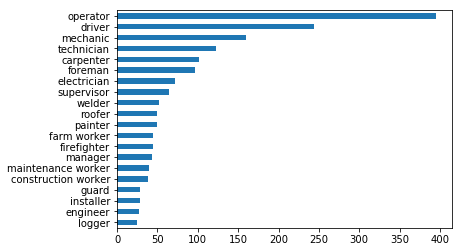

operator               395
driver                 244
mechanic               160
technician             122
carpenter              101
foreman                 96
electrician             72
supervisor              64
welder                  52
roofer                  49
painter                 49
farm worker             45
firefighter             45
manager                 43
maintenance worker      39
construction worker     38
guard                   29
installer               29
engineer                27
logger                  25
dtype: int64
OSHA occupations word cloud:


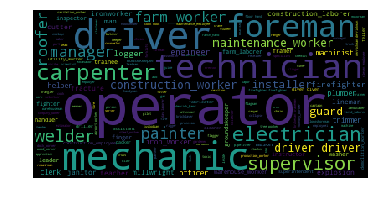

In [14]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ast import literal_eval

wnl = nltk.WordNetLemmatizer()  # initialize Lemmatizer

# FIXME rules cannot match all the situations
# chunk sequences of proper nouns phrase
grammar_title = '''
NP: {<NN.*>+}
CLAUSE: {^<CD>?<NP><POS>?<NN.*>*<VB.*>}
'''
cp_title = nltk.RegexpParser(grammar_title)

grammar_summary = '''
NP: {<NN.*>+}
CLAUSE: {<\#><CD><DT>?<NP>}
'''
cp_summary = nltk.RegexpParser(grammar_summary)

stops = ['employee', 'worker', 'laborer', 'owner', 'coworker', 'contractor']  # meaningless occupation term list
errors = ['age', 'hand', 'male']

def trasverse_tree(chunked):
    for n1 in chunked:
        if isinstance(n1, nltk.tree.Tree) and n1.label() == 'CLAUSE':
            for n2 in n1:
                if isinstance(n2, nltk.tree.Tree) and n2.label() == 'NP':
                    lem = [wnl.lemmatize(w) for w, t in n2]
                    # reject 'worker' but accept 'farm worker'
                    if lem[0] not in (stops+errors):
                        if len(lem) > 1 and lem[-1] not in (stops+errors):
                            lem = [lem[-1]]
                        return ' '.join(lem)


def parse_title_occupation(text):
    '''
    Extract occupation information from input
    :param text: string storing pos tag
    :return: occupation term
    '''
    pos = literal_eval(text)  # string to list
    chunked = cp_title.parse(pos)  # chunking
    
    return trasverse_tree(chunked)


def parse_summary_occupation(text):
    pos = literal_eval(text)  # string to list
    try:
        first_sent = pos[:pos.index(('.', '.'))]  # parse first sentence with pos tag
    except ValueError:
        return None
    chunked = cp_summary.parse(first_sent)  # chunking

    return trasverse_tree(chunked)


print('Parsing Title ...')
osha_title_occupation = osha.Title_POS.apply(parse_title_occupation)

print('Parsing Summary ...')
osha_summary_occupation = osha[osha_title_occupation.isnull()]['Summary_POS'].apply(parse_summary_occupation)

osha_title_occupation = osha_title_occupation.dropna()  # remove all None value
osha_summary_occupation = osha_summary_occupation.dropna()  # remove all None value
osha_occupation = pd.concat([osha_title_occupation, osha_summary_occupation])  # Concatenating together

# visualization
print('Top 10 risky occupations for OSHA dataset:')
osha_occupation_count = osha_occupation.groupby(osha_occupation).size().sort_values(ascending=False)
osha_occupation_count.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()
print(osha_occupation_count.head(20))
print('OSHA occupations word cloud:')
osha_word_string = ' '.join([w.replace(' ', '_') for w in osha_occupation])
osha_word_cloud = WordCloud().generate(osha_word_string)
plt.imshow(osha_word_cloud)
plt.axis('off')
plt.show()

## Which parts of human body are more prone to be injured in such accidents?

To extract common injured human body parts in accidents, we first observe the preprocessed dataset and we found that at most cases, the Keywords column contain human body parts information. Hence, we split each Keywords column and match the created term list with the prepared human body terms list crawling from internet and conduct statistic on the result.

Top 10 common injured of human body parts for OSHA dataset:


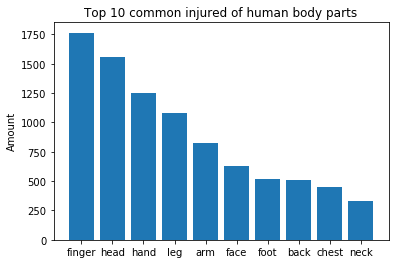

finger:	1764
head:	1556
hand:	1249
leg:	1081
arm:	821
face:	629
foot:	515
back:	512
chest:	447
neck:	333
OSHA injured of human body parts word cloud:


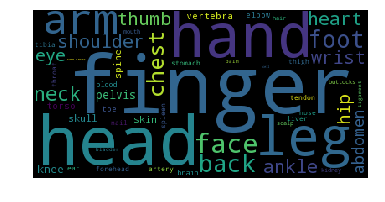

In [10]:
import re
import pickle
from collections import Counter
import numpy as np

# load body terms list
try:
    human_body_terms = pickle.load(open("data/human_body_terms.pk", "rb"))
except FileNotFoundError:
    page = requests.get('http://www.enchantedlearning.com/wordlist/body.shtml')
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', {'border': '1'})
    tds = table.findAll("td")
    [center.extract() for td in tds for center in td.findAll('center')]
    human_body_terms = [term for td in tds for term in re.split('\n+', td.text.strip())]
    pickle.dump(human_body_terms, open("data/human_body_terms.pk", "wb"))


def get_body_parts(text):
    '''
    Extract human body term from input
    :param text: str
    :return: list containing body terms
    '''
    keywords = text.split()
    body_parts = [k for k in keywords if k in human_body_terms]
    if body_parts:
        return body_parts


if __name__ == "__main__":
    osha_body_parts = osha.Keywords.apply(get_body_parts)

    osha_body_parts = osha_body_parts.dropna()  # remove all None value

    # visualization
    print('Top 10 common injured of human body parts for OSHA dataset:')
    osha_body_parts_statistic = {}
    for parts in osha_body_parts:
        for part in parts:
            if part not in osha_body_parts_statistic:
                osha_body_parts_statistic.update({part: 1})
            else:
                osha_body_parts_statistic[part] += 1
    top_10 = Counter(osha_body_parts_statistic).most_common(10)  # find top 10 common injured of human body parts
    objects = tuple([o for o, c in top_10])
    y_pos = np.arange(len(objects))
    count = [c for o, c in top_10]
    plt.bar(y_pos, count)
    plt.xticks(y_pos, objects)
    plt.ylabel('Amount')
    plt.title('Top 10 common injured of human body parts')
    plt.show()
    for o, c in top_10: print('%s:\t%d' % (o, c))

    print('OSHA injured of human body parts word cloud:')
    osha_word_string = ' '.join([' '.join(w) for w in osha_body_parts])
    
    osha_word_cloud = WordCloud().generate_from_frequencies(osha_body_parts_statistic)
    plt.imshow(osha_word_cloud)
    plt.axis('off')
    plt.show()
    print